In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -U albumentations

In [ ]:
pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
pip install opencv-python-headless==4.5.2.52

In [20]:
import os
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
# from efficientnet.keras import preprocess_input
from keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Layer, ReLU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, AveragePooling2D, ReLU, AlphaDropout, Conv2D, GlobalAveragePooling2D, Dense, Add, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, VGG16, MobileNetV2, ResNet50V2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from keras.utils import load_img, img_to_array

import cv2
import albumentations as A

tf.get_logger().setLevel(logging.ERROR)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
img_rows, img_cols = 224, 224
channel_depth = 3
input_shape = (img_rows,img_cols,channel_depth)
model_input = Input(shape=input_shape)


# DenseNet121

In [128]:
def my_model1(model_input):
    densenet = DenseNet121(weights='imagenet', include_top=False, input_tensor=model_input)
    for layer in densenet.layers:layer.trainable = False
    # our layers - you can add more if you want
    y = GlobalAveragePooling2D()(densenet.output)
    y = Dense(512, activation='relu', use_bias=True)(y)
    y = Dropout(0.5)(y)
    prediction = Dense(5,activation='softmax')(y)
    model = Model(inputs=densenet.input, outputs=prediction)
    # tell the model what cost and optimization method to use
    return model

In [137]:
model1 = my_model1(model_input)

In [ ]:
#model1.load_weights('/content/drive/MyDrive/weights/stage1/densenet121_1.h5')

# InceptionV3

In [127]:
def my_model2(model_input):
    InceptionV3_builder = InceptionV3(
        weights='imagenet', 
        include_top=False, 
        input_tensor = model_input
    )

#FINE-TUNING
    for layer in InceptionV3_builder.layers:
        layer.trainable = False
    for BatchNormalization in InceptionV3_builder.layers:
        BatchNormalization.trainable = True
    x = InceptionV3_builder.layers[-1].output    
    x = GlobalAveragePooling2D(name='GAP-inceptionv3')(x)
    x = Dropout(0.5, name='Droput-inceptionv3')(x)
    predictions = Dense(5, activation='softmax', name='Softmax-inceptionv3')(x)
    model = Model(inputs=InceptionV3_builder.input, outputs=predictions, name='inceptionv3')
    return model

In [138]:
model2 = my_model2(model_input)

In [ ]:
#model2.load_weights('/content/drive/MyDrive/weights/stage1/InceptionV3_1.h5')

# VGG16

In [126]:
def my_model3(model_input):
    densenet = VGG16(weights='imagenet', include_top=False, input_tensor=model_input)
    for layer in densenet.layers:layer.trainable = False
    # our layers - you can add more if you want
    y = GlobalAveragePooling2D()(densenet.output)
    y = Dense(512, activation='relu', use_bias=True)(y)
    y = Dropout(0.5)(y)
    prediction = Dense(5,activation='softmax')(y)
    model = Model(inputs=densenet.input, outputs=prediction)
    # tell the model what cost and optimization method to use
    return model

In [139]:
model3 = my_model3(model_input)

In [140]:
#model3.load_weights('/content/drive/MyDrive/weights/stage1/VGG16_1.h5')

# Fusion Model

In [141]:
models = [model1, model2, model3]

In [142]:
[m.layers[0] for m in models]

In [143]:
outputs = [m.output for m in models]
y = tf.keras.layers.Average()(outputs)
TDCNN_1 = Model(model_input, y, name='TDCNN_1')

In [144]:
TDCNN_1.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [113]:
train_path="/content/drive/MyDrive/Dataset Moisture Kopi/train"
validation_path= "/content/drive/MyDrive/Dataset Moisture Kopi/validation"
test_path="/content/drive/MyDrive/Dataset Moisture Kopi/test"

In [38]:
!mkdir datacof
!mkdir datacof/15

In [39]:
import shutil

In [114]:
IMG_SIZE = (224,224)

def ImgDataGen(file_path):
    file_datagen = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=30,
                      horizontal_flip=True,
                      width_shift_range = 0.2,
                      height_shift_range = 0.2,
                      shear_range = 0.1,
                      fill_mode = 'nearest'
                      )
    
    data_set = file_datagen.flow_from_directory(file_path,
                                                target_size = IMG_SIZE,
                                                batch_size = 16,
                                                class_mode = 'categorical')
    return data_set


In [115]:
training_set, val_set, test_set = ImgDataGen(train_path), ImgDataGen(validation_path), ImgDataGen(test_path)

Found 109 images belonging to 5 classes.
Found 10 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [116]:
training_set.class_indices

{'13,2_': 0, '13_': 1, '14_': 2, '15_': 3, '_15_': 4}

In [124]:
nb_train_samples = len(training_set.filenames)
nb_validation_samples = len(val_set.filenames)

In [145]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
import time

batch_size = 16

epochs = 25

start_time = time.time()

optimizer = Adam(learning_rate=0.0001)

TDCNN_1.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
) 

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=2,                          
    verbose=1, 
    mode='max', 
    min_lr=0.000001
)

callbacks = [reduce_lr]

history = TDCNN_1.fit(
    training_set,
    epochs=epochs, 
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=val_set,
    callbacks=callbacks, 
    validation_steps=nb_validation_samples // batch_size, 
    verbose=1
)

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))





Epoch 1/25
6/6 [==============================] - 140s 20s/step - loss: 1.7413 - accuracy: 0.1875 - lr: 1.0000e-04
Epoch 2/25
6/6 [==============================] - 116s 19s/step - loss: 1.5019 - accuracy: 0.2903 - lr: 1.0000e-04
Epoch 3/25
6/6 [==============================] - 114s 19s/step - loss: 1.2670 - accuracy: 0.5161 - lr: 1.0000e-04
Epoch 4/25
6/6 [==============================] - 120s 20s/step - loss: 1.1925 - accuracy: 0.6022 - lr: 1.0000e-04
Epoch 5/25
6/6 [==============================] - 118s 19s/step - loss: 1.0815 - accuracy: 0.6354 - lr: 1.0000e-04
Epoch 6/25
6/6 [==============================] - 116s 19s/step - loss: 0.9978 - accuracy: 0.6989 - lr: 1.0000e-04
Epoch 7/25
6/6 [==============================] - 120s 20s/step - loss: 0.9879 - accuracy: 0.7604 - lr: 1.0000e-04
Epoch 8/25
6/6 [==============================] - 121s 20s/step - loss: 0.8986 - accuracy: 0.7812 - lr: 1.0000e-04
Epoch 9/25
6/6 [==============================] - 118s 19s/step - loss: 0.7718 -

'00:54:36'

KeyError: ignored

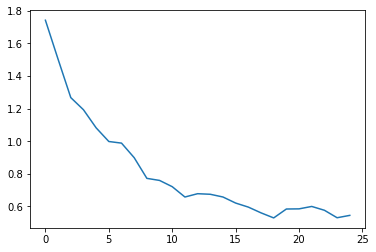

In [148]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

KeyError: ignored

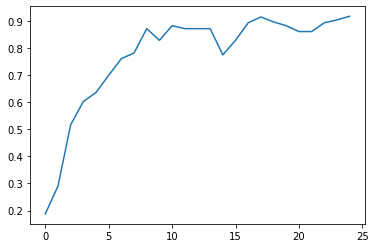

In [149]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [151]:
TDCNN_1.evaluate(test_set,batch_size=32)

1/1 [==============================] - 15s 15s/step - loss: 1.8761 - accuracy: 0.4000


[1.8760744333267212, 0.4000000059604645]

1/1 [==============================] - 10s 10s/step - loss: 2.0548 - accuracy: 0.2000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       1.00      0.25      0.40         8
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.20        10
   macro avg       0.20      0.05      0.08        10
weighted avg       0.80      0.20      0.32        10



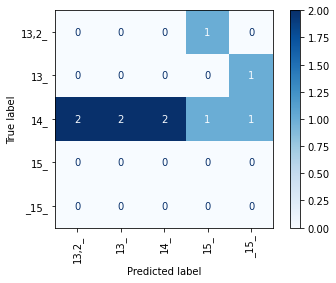

In [153]:
def report_test(test_set,model=TDCNN_1):
    
    # evaluating test
    model.evaluate(test_set,batch_size=32)
    y_pred=model.predict(test_set)
    y_pred=np.argmax(y_pred,axis=1)
    accuracy_score(y_pred,test_set.classes)
    print(classification_report(y_pred,test_set.classes))
    
    # confusion_matrix
    labels = [i for i in training_set.class_indices]
    cm =confusion_matrix(y_pred, test_set.classes)
    disp = ConfusionMatrixDisplay(cm,display_labels=labels)
    disp.plot(cmap='Blues',xticks_rotation='vertical')
    plt.show()

report_test(test_set)

In [154]:
file_model = "weights/TDCNN_1.h5"
tf.keras.models.save_model(TDCNN_1,file_model)